# Coding Drill 03

## 1. Target

- Reduce number of parameters < 10K, trying to achieve accuracy within 15 EPOCHs
- Since we are reducing the parameters, there might be accuracy reduction
- Try improving based on data and by adjusting available layers


## Key Updates

- Data
  - Enabled data-trasnforms for training (normalized them) 
  - Enabled random rotations so that model learns better ( -7deg to +7 deg)
    - This could be  observed from data. So use in training
- Model: This will be the baseline model to tune further
  - Utilized Batch Normalization, Dropouts

- Training
 - Lets start with 15 EPOCHs
 - Include LR scheduler

## 2. Result

- Params: `9,707`
- Train Accuracy: `99.8%`
- Test Accuracy : `99.1%`

## 3. Analysis

- The parameters have reduced < 10K 
- The model is overfitting and the test accuracy has reduced less than coding drill 1 (But the EPOCH is 15 now)



# Import Libraries

In [ ]:
# import all the required torch functions
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


# Include Data Transformations

- We first start with defining our data transformations.
- We need to think what our data is and how can we augment it to represent  represent correctly which it might not see otherwise. 

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                            # Note the difference between (0.1307) and (0.1307,)
                        ])

# Test Phase transformations
test_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])

# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Check for GPU availability

In [ ]:
SEED = 1

# CUDA? Check for GPU availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# Setup Seed, for reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The Model

- Let's start with model from where we achieved < 20K params (Earlier assignment S3) 

In [ ]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(30),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary

# Once we have GPU ready to access, the next step is getting PyTorch to use for storing data (tensors) and computing on data (performing operations on tensors).
# test if PyTorch has access to a GPU
use_cuda = torch.cuda.is_available()

# if GPU is availble use it, if not use CPU. allocate device and assign n/w to it
device = torch.device("cuda" if use_cuda else "cpu")

# configure the model to be loaded on the device decided above.
model = Net().to(device)

# input image size: 28x28, Input_channels: 1
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 30, 24, 24]           3,780
              ReLU-6           [-1, 30, 24, 24]               0
       BatchNorm2d-7           [-1, 30, 24, 24]              60
           Dropout-8           [-1, 30, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             300
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
    

# Training and Testing

- Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 
- Let's write train and test functions

In [ ]:
# Tqdm is a library in Python which is used for creating Progress Meters or Progress Bars.
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  
  model.train() # set the model with training mode (this is the default mode)

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init. 
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict. 
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return 100*correct/processed

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return 100. * correct / len(test_loader.dataset)


In [ ]:
from torch.optim.lr_scheduler import StepLR

# move the model to the required device, GPU if available, if not on CPU.
model = Net().to(device)

# create an optimizer (SGD) with required parameters, 
# model.parameters() - these are the model parameters to optimize, 
# learning-rate lr=0.01 and momentum-0.9
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# Configure epochs to train for
EPOCHS = 15

prev_train_acc = -1
prev_test_acc = -1
train_accuracy = 0
test_accuracy = 0

# run single epoch as of now.
for epoch in range(EPOCHS):
    print(f'Epoch: {epoch+1}')

    # train the model loaded on the device with the required optimizer
    train_accuracy = train(model, device, train_loader, optimizer, epoch)

    # set to the next lr params
    scheduler.step()

    # we need to evaluate on test data
    test_accuracy = test(model, device, test_loader)


    # check difference from previous accuracies for better understanding
    if -1 == prev_train_acc:
      prev_train_acc = train_accuracy
    if -1 == prev_test_acc:
      prev_test_acc = test_accuracy

    print(f'train_acc_diff: {train_accuracy - prev_train_acc:.3f} test_acc_diff: {test_accuracy - prev_test_acc:.3f} test_train_diff: {test_accuracy - train_accuracy:.3f}\n')
    prev_train_acc = train_accuracy
    prev_test_acc = test_accuracy


Epoch: 1


Loss=0.1192144975066185 Batch_id=468 Accuracy=87.05: 100%|██████████| 469/469 [00:23<00:00, 20.13it/s]



Test set: Average loss: 0.1040, Accuracy: 9718/10000 (97.18%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 10.135

Epoch: 2


Loss=0.0931224450469017 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]



Test set: Average loss: 0.0571, Accuracy: 9836/10000 (98.36%)

train_acc_diff: 10.217 test_acc_diff: 1.180 test_train_diff: 1.098

Epoch: 3


Loss=0.10807701200246811 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:19<00:00, 24.49it/s]



Test set: Average loss: 0.0716, Accuracy: 9777/10000 (97.77%)

train_acc_diff: 0.555 test_acc_diff: -0.590 test_train_diff: -0.047

Epoch: 4


Loss=0.021843736991286278 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:19<00:00, 24.62it/s]



Test set: Average loss: 0.0407, Accuracy: 9870/10000 (98.70%)

train_acc_diff: 0.200 test_acc_diff: 0.930 test_train_diff: 0.683

Epoch: 5


Loss=0.08887781947851181 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:19<00:00, 24.11it/s]



Test set: Average loss: 0.0333, Accuracy: 9896/10000 (98.96%)

train_acc_diff: 0.268 test_acc_diff: 0.260 test_train_diff: 0.675

Epoch: 6


Loss=0.02476615272462368 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]



Test set: Average loss: 0.0400, Accuracy: 9872/10000 (98.72%)

train_acc_diff: 0.052 test_acc_diff: -0.240 test_train_diff: 0.383

Epoch: 7


Loss=0.15151216089725494 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:18<00:00, 25.08it/s]



Test set: Average loss: 0.0266, Accuracy: 9910/10000 (99.10%)

train_acc_diff: 0.295 test_acc_diff: 0.380 test_train_diff: 0.468

Epoch: 8


Loss=0.01854022592306137 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:18<00:00, 25.05it/s]



Test set: Average loss: 0.0262, Accuracy: 9917/10000 (99.17%)

train_acc_diff: 0.132 test_acc_diff: 0.070 test_train_diff: 0.407

Epoch: 9


Loss=0.03188866376876831 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:18<00:00, 24.92it/s]



Test set: Average loss: 0.0263, Accuracy: 9913/10000 (99.13%)

train_acc_diff: -0.013 test_acc_diff: -0.040 test_train_diff: 0.380

Epoch: 10


Loss=0.01299874484539032 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:18<00:00, 24.80it/s]



Test set: Average loss: 0.0268, Accuracy: 9914/10000 (99.14%)

train_acc_diff: -0.028 test_acc_diff: 0.010 test_train_diff: 0.418

Epoch: 11


Loss=0.021741269156336784 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]



Test set: Average loss: 0.0267, Accuracy: 9914/10000 (99.14%)

train_acc_diff: 0.040 test_acc_diff: 0.000 test_train_diff: 0.378

Epoch: 12


Loss=0.0848524197936058 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:18<00:00, 25.15it/s]



Test set: Average loss: 0.0263, Accuracy: 9911/10000 (99.11%)

train_acc_diff: 0.032 test_acc_diff: -0.030 test_train_diff: 0.317

Epoch: 13


Loss=0.02959776110947132 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:18<00:00, 25.25it/s]



Test set: Average loss: 0.0256, Accuracy: 9917/10000 (99.17%)

train_acc_diff: -0.023 test_acc_diff: 0.060 test_train_diff: 0.400

Epoch: 14


Loss=0.03071838617324829 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:18<00:00, 24.89it/s]



Test set: Average loss: 0.0259, Accuracy: 9911/10000 (99.11%)

train_acc_diff: 0.055 test_acc_diff: -0.060 test_train_diff: 0.285

Epoch: 15


Loss=0.01428589690476656 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]



Test set: Average loss: 0.0257, Accuracy: 9910/10000 (99.10%)

train_acc_diff: -0.023 test_acc_diff: -0.010 test_train_diff: 0.298



# Move tesnors to numpy as required

- train_losses is a list, but train_losses[i] is a tensor
- all others are numpy

## APIs to use

- To go from np.array to cpu Tensor    => torch.from_numpy().
- To go from cpu Tensor to gpu Tensor  => .cuda()
- To go from a Tensor that requires_grad to one that does not => .detach() 
- To go from a gpu Tensor to cpu Tensor => .cpu()
- To gp from a cpu Tensor to np.array   => .numpy()

In [ ]:
# type(train_losses), type(train_losses[0])

for i, loss in enumerate(train_losses):
  train_losses[i] = loss.detach().cpu().numpy()

# Plot the model's learning progress

- Plot training and test accuracies

Text(0.5, 1.0, 'Test Accuracy')

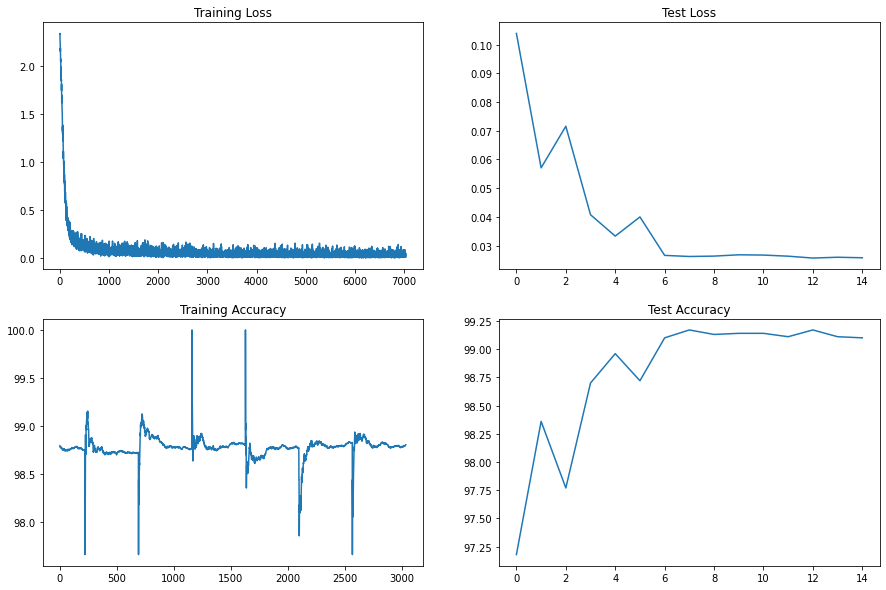

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")